In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


tensor(0.0339, dtype=torch.float64)

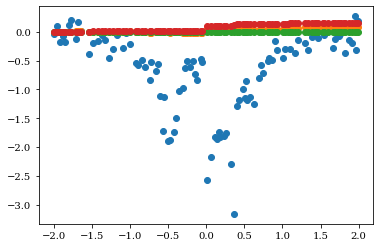

In [3]:
plt.scatter(logsig[0, :, 0], logsig[0, :, 1])
plt.scatter(logsig[0, :, 0], logsig[0, :, 2])
plt.scatter(logsig[0, :, 0], logsig[0, :, 3])
plt.scatter(logsig[0, :, 0], logsig[0, :, 4])
logsig[:, :, 2:].mean()

In [4]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_859.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [5]:
size = 4096 * 4

In [6]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device)

  0%|          | 0/4 [00:00<?, ?it/s]

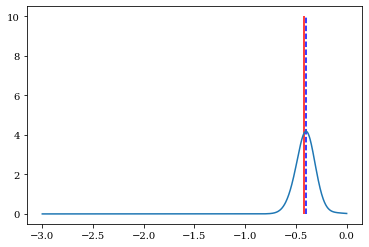

In [27]:
i = 15; dim = 1
qgrid = torch.linspace(-3, 0, 1000)
qlist = qgrid.reshape(-1, 1, 1).tile(1, 1, 1)
plt.plot(qgrid, get_loglik(pis[[i]], locs[[i]], scales[[i]], qlist, margin_dim=dim, exp=True)[:, 0])
peaks = find_peaks(get_loglik(pis[[i]], locs[[i]], scales[[i]], qlist, margin_dim=dim, exp=False).transpose(1, 0)[0])[0]
plt.vlines(Y[i, dim], 0, 10, color='red')
plt.vlines(qgrid[peaks], 0, 10, color='blue', linestyles='dashed')

In [28]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [29]:
print(pred_global_loglik.sum(dim=1).mean(), pred_close_loglik.sum(dim=1).mean())

tensor(10.8336) tensor(10.2259)


In [18]:
pred_global = infer_lgfs(X.numpy(), pred_global.numpy())
pred_global = torch.tensor(pred_global)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [19]:
pred_close = infer_lgfs(X.numpy(), pred_close.numpy())
pred_close = torch.tensor(pred_close)

  0%|          | 0/4096 [00:00<?, ?it/s]

/home/hmzhao/latent-ode-microlensing/model/utils.py:55: RuntimeWarning: invalid value encountered in log10
  lgfs[i, 0] = np.log10(fs / (fs + fb))


mse of log10q global:  0.07194181867538824
mse of log10q close:  0.033571711156828665
constraint 0.9921875
correct 0.9140625
mse of log10s global:  0.013578901572700742
mse of log10s close:  0.0018517044069324864
constraint 0.98199462890625
correct 0.8784884082292249
mse of u0:  0.01076786907088534
mse of u0:  0.0038600547244058304
constraint 0.98828125
correct 0.8997653162055336
mse of alpha global:  6466.37914026344
mse of alpha close:  261.95332530178126
constraint 0.98406982421875
correct 0.7729951001674626
mse of log10fs global:  0.0028687625726472694
mse of log10fs close:  0.0016350199531688027


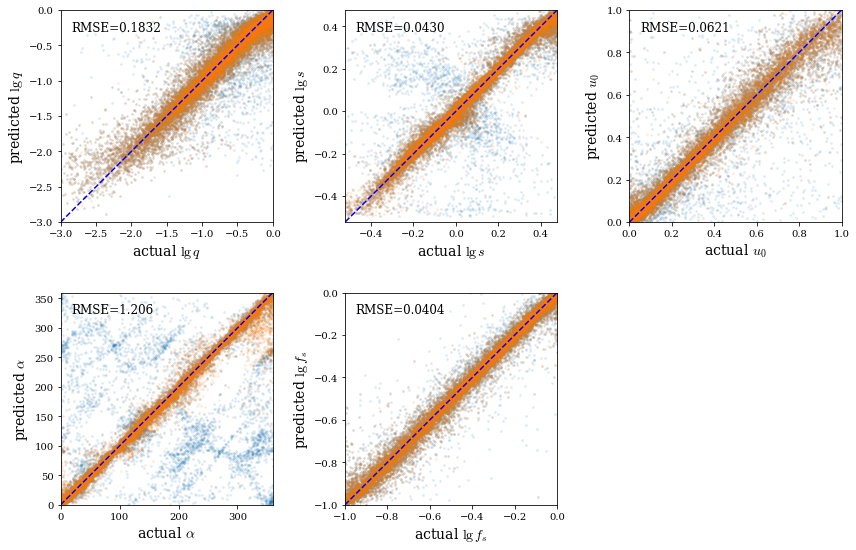

In [30]:
# plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title='500 irregular, 33 S/N', plot_rho=True, save='./500ir33SN.pdf')
rmse = plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title=None, save='./500ir33SN.pdf')

# Subsample

In [31]:
n_points = 100
subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

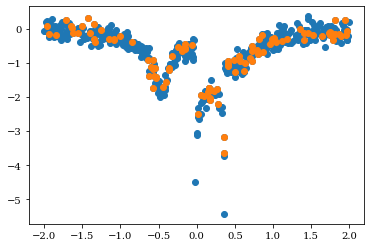

In [32]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_sub[i, :, 0], X_sub[i, :, 1])

In [33]:
# CDE interpolation with log_sig
depth = 3; window_length = max(n_points//100, 1)
logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [35]:
pis_sub, locs_sub, scales_sub = inference(model, size, 4096, coeffs, device)

  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
pred_sub = get_peak_pred(pis_sub, locs_sub, scales_sub, Y)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.1808628681725546
mse of log10q close:  0.1023983806818968
constraint 0.99285888671875
correct 0.8350033810782566
mse of log10s global:  0.0317871101939358
mse of log10s close:  0.005050112324092483
constraint 0.9830322265625
correct 0.7189246243635912
mse of u0:  0.021713779067972637
mse of u0:  0.007955089606380344
constraint 0.98712158203125
correct 0.8176590613986273
mse of alpha global:  10231.009884160521
mse of alpha close:  417.0702001290098
constraint 0.98724365234375
correct 0.6123029366306028
mse of log10fs global:  0.0074234620752337095
mse of log10fs close:  0.004381206224895991


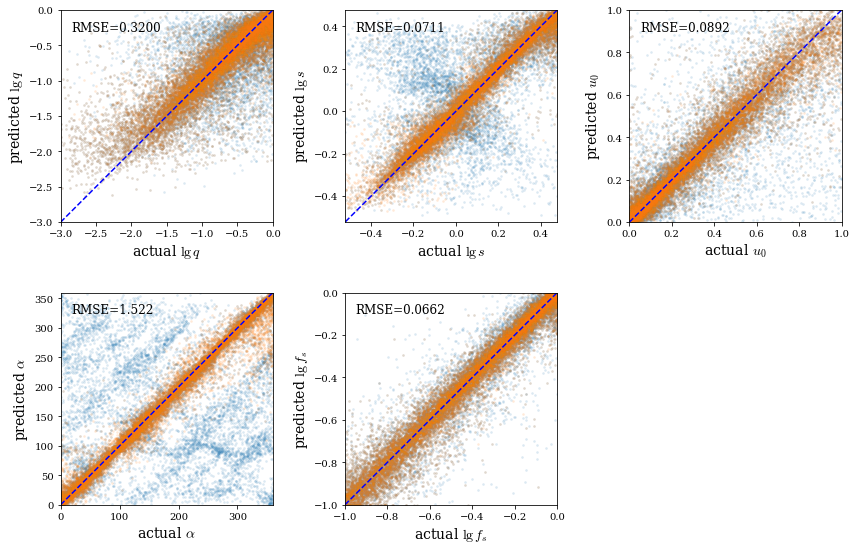

In [38]:
# plot_params(size, Y, *pred_sub, title=f'{n_points} irregular, 33 S/N', save=f'./{n_points}ir33SN.pdf')
rmse_sub = plot_params(size, Y, *pred_sub, title=None, save=f'./{n_points}ir33SN.pdf')

In [39]:
pred_sub[1].sum(dim=1).mean(), pred_sub[3].sum(dim=1).mean()

(tensor(10.3451), tensor(8.3614))

In [ ]:
n_points_list = [400, 300, 200, 100]
mse_global = np.zeros((len(n_points_list), output_dim))
mse_close = np.zeros((len(n_points_list), output_dim))
loglik_global = np.zeros((len(n_points_list), output_dim))
loglik_close = np.zeros((len(n_points_list), output_dim))
for i in tqdm(range(len(n_points_list))):
    n_points = n_points_list[i]
    subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
    X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
    order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
    X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

    # CDE interpolation with log_sig
    depth = 3; window_length = max(n_points//100, 1)
    logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

    pis, locs, scales = inference(model, size, 4096, coeffs)
    pred_sub = get_peak_pred(pis, locs, scales)

    mse_global[i] = torch.mean((pred_sub[0] - Y[:size])**2, dim=0).numpy()
    mse_close[i] = torch.mean((pred_sub[2] - Y[:size])**2, dim=0).numpy()
    loglik_global[i] = torch.mean(pred_sub[1], dim=0).numpy()
    loglik_close[i] = torch.mean(pred_sub[3], dim=0).numpy()

np.save('./mse_sub.npy', mse_close)

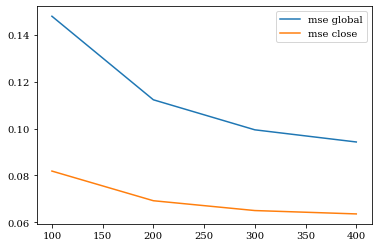

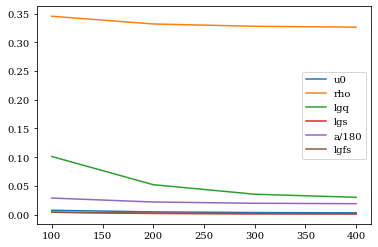

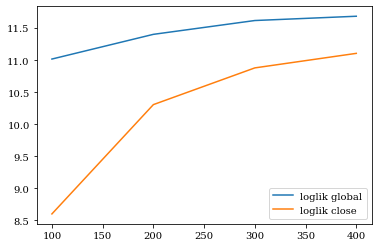

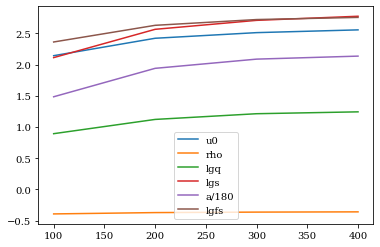

In [ ]:
plt.plot(n_points_list, mse_global.mean(1), label='mse global')
plt.plot(n_points_list, mse_close.mean(1), label='mse close')
plt.legend()
plt.show()
plt.plot(n_points_list, mse_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_global.sum(1), label='loglik global')
plt.plot(n_points_list, loglik_close.sum(1), label='loglik close')
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()

# Gap
Gap length: 5 days = 1/6 tE = 1/24 4tE

In [41]:
n_chunks = 25
gap_len = int(500 / n_chunks)
gap_left = torch.randint(0, X.shape[1]-gap_len, (len(X),))
X_gap = torch.zeros((X.shape[0], X.shape[1]-gap_len, X.shape[2]))
for i in tqdm(range(len(X))):
    left, gap, right = torch.split(X[i], [gap_left[i], gap_len, X.shape[1]-gap_left[i]-gap_len], dim=0)
    lc = torch.vstack([left, right])
    X_gap[i] = lc

  0%|          | 0/100000 [00:00<?, ?it/s]

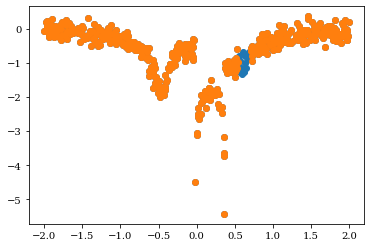

In [42]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])

In [43]:
# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [45]:
pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs, device)

  0%|          | 0/4 [00:00<?, ?it/s]

In [47]:
pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap, Y)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.07645586302080136
mse of log10q close:  0.03763054552652344
constraint 0.99322509765625
correct 0.9104651877342838
mse of log10s global:  0.014511998007188063
mse of log10s close:  0.0019218633568419607
constraint 0.98138427734375
correct 0.8660364450525531
mse of u0:  0.011663608080675932
mse of u0:  0.003956700578892095
constraint 0.98834228515625
correct 0.8908170196998703
mse of alpha global:  6696.900037856027
mse of alpha close:  264.2942754407211
constraint 0.984619140625
correct 0.7599181750557897
mse of log10fs global:  0.0030737125151016178
mse of log10fs close:  0.0017540620577256873


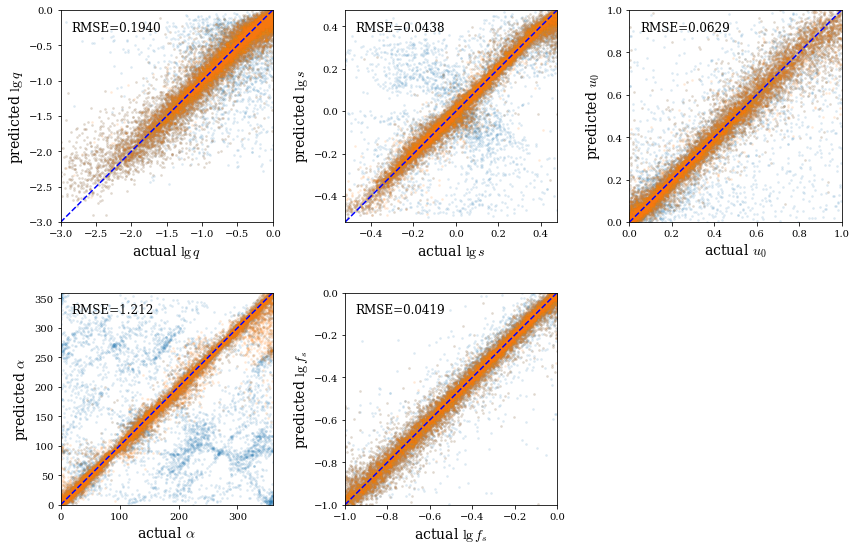

In [49]:
# plot_params(size, Y, *pred_gap, title='500 irregular, 33 S/N, 1 gap of 1/6 tE', save='./500ir33SN1gap.pdf')
# rmse_gap = plot_params(size, Y, *pred_gap, title=None, save='./500ir33SN1gap.pdf',
#                         example_groundtruth=param_gt_example, example_pred=param_predgap_example)
rmse_gap = plot_params(size, Y, *pred_gap, title=None, save='./500ir33SN1gap.pdf')

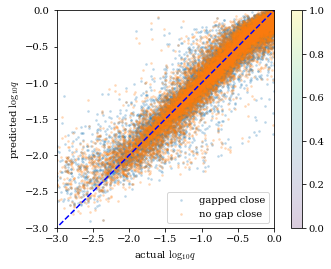

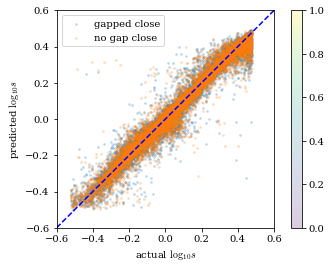

In [53]:
num = size
plt.axis('square')
plt.xlim(-3, 0)
plt.ylim(-3, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 1], pred_gap[2].numpy()[:num, 1], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 2], pred_gap[2].numpy()[:num, 2], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()

In [54]:
pred_gap[1].sum(dim=1).mean(), pred_gap[3].sum(dim=1).mean()

(tensor(10.8078), tensor(10.1146))

In [62]:
i = torch.mean((pred_close - pred_global)**2, dim=-1).sort()[1][:10]
i, #Y[i], pred_close[i], pred_global[i]

(tensor([ 7088,  7078, 12607, 12603,  7081, 12600,  7083,  7084,  7085,  7086]),)

(tensor([ 0.7546, -0.4145,  0.1111,  1.3242, -0.1716], dtype=torch.float64),
 tensor([ 0.7417, -0.3924,  0.1123,  1.3253, -0.1822]),
 tensor([ 0.7077, -0.4364,  0.1075,  1.3153, -0.1952]))

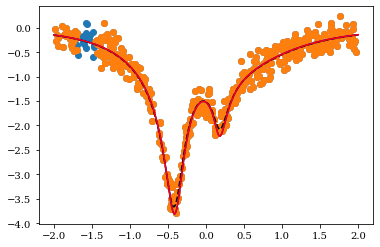

In [67]:
i = 12607
# plt.xlim(-0.5, 0.5)
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])
lc_true = simulate_lc(0, 1, Y[i, 0].item(), -3, Y[i, 1].item(), Y[i, 2].item(), Y[i, 3].item(), Y[i, 4].item())
lc_pred = simulate_lc(0, 1, pred_close[i, 0].item(), -3, pred_close[i, 1].item(), pred_close[i, 2].item(), pred_close[i, 3].item(), pred_close[i, 4].item())
lc_pred_gap = simulate_lc(0, 1, pred_global[i, 0].item(), -3, pred_global[i, 1].item(), pred_global[i, 2].item(), pred_global[i, 3].item(), pred_global[i, 4].item())
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', )
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', )
Y[i], pred_close[i], pred_gap[2][i]

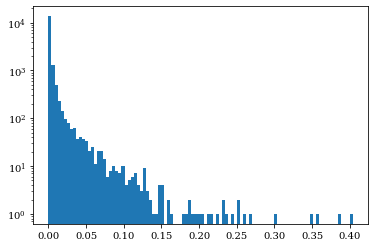

In [68]:
plt.hist((torch.mean(X[:size, :, 1], dim=1) - torch.mean(X_gap[:size, :, 1], dim=1)).numpy()**2, bins=100, log=True)
plt.show()

In [69]:
ind = (torch.mean(X[:, :, 1], dim=1) - torch.mean(X_gap[:, :, 1], dim=1)).numpy()**2 > 0.05
ind[size:] = False

In [70]:
torch.mean((Y[ind][:size] - pred_gap[2][ind[:size]])**2, dim=1).argsort()

tensor([248, 193, 138, 201,  30, 241,  48, 243, 245, 194,  82,  73, 134, 167,
         56,  92,   2,  33, 195,  49,  61, 240, 132, 126,   1,  41, 183, 125,
         39, 196, 242, 177, 199,  70, 146, 123,  36,  27, 108, 128, 226, 171,
         29, 150, 217, 239,  96, 111,  68, 151, 225, 231,  93, 181, 117, 223,
        169, 162, 104,  50, 172,  90, 210, 152, 144, 228, 175, 216, 247, 107,
        222, 244,  54, 220,  59, 131,  63,  43, 250,  44,  86,  12, 214,  77,
         81, 203, 141, 143, 121, 147, 237,  74,  89, 229,  31,  45, 192,  72,
         84,  65, 213,  98, 164, 186,  76, 163, 198, 208, 118,  71, 230,  15,
        209, 249, 190, 232, 137,  80,  55, 156,  24,  66, 161, 206, 170,  94,
        197,   9,  18, 139,   8,  19, 112, 176, 149,  79,  51,  69,   3, 160,
        122, 251, 142,  62,  53,  64,  99, 140,  26,  95,  11,  38, 205, 191,
        236,  83, 103, 101, 153,  17, 120,  16,  88,  13, 204, 219, 188, 252,
         57, 102,  67, 133, 157,  40, 179,  47, 154,  78, 184, 2

Gap recovered: 

with rho: 77**, 53**, 68*, 20, 140, 228*, 146, 28, 50, 26, 194*, 97*

drop rho: 56*, 92, 126, 128*, 151, 107, 214, 72*

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.12972104 -1.98346295 -0.04069173  0.6920934  -0.09253528]
pred no gap:  [ 0.13213213 -1.941942   -0.03783785  0.6786787  -0.08508509]
pred gap close:  [ 0.14814815 -1.8218218  -0.06186187  0.6566566  -0.08408409]
pred gap global:  [ 0.14814815 -1.8218218  -0.06186187  0.6566566  -0.08408409]
tensor(84)


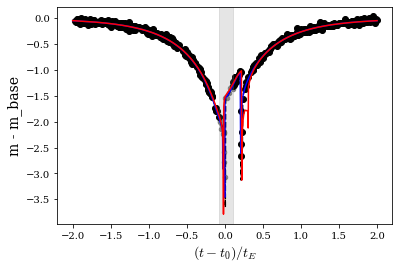

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.0493794  -1.74294252  0.44337957  1.9732931  -0.39173852]
pred no gap:  [ 0.06506506 -1.6936936   0.42342347  0.0960961  -0.3873874 ]
pred gap close:  [ 0.03003003 -1.6336336   0.3741742   1.8678678  -0.3853854 ]
pred gap global:  [ 0.03003003 -1.6336336   0.3741742   1.8678678  -0.3853854 ]
tensor(65)


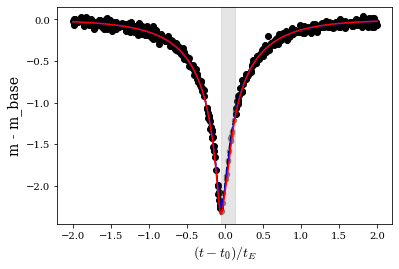

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.05586538 -1.49898916  0.11308906  0.12228979 -0.25016127]
pred no gap:  [ 0.06106106 -1.2572572  -0.15315317  0.8548548  -0.24924925]
pred gap close:  [ 0.13013013 -1.5175174   0.21921924  0.22822823 -0.23023023]
pred gap global:  [ 0.13013013 -1.5175174  -0.0930931   0.9229229  -0.23023023]
tensor(213)


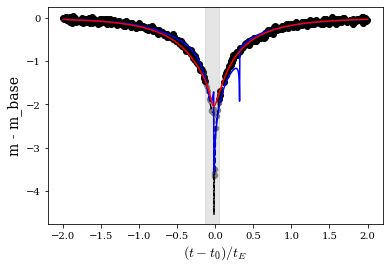

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.07110025 -0.94508902 -0.26216814  0.31084361 -0.00837625]
pred no gap:  [ 0.07107107 -0.8528528  -0.27567568  0.3263263  -0.00700701]
pred gap close:  [ 0.0970971  -0.7927928  -0.30210212  0.36836836  0.        ]
pred gap global:  [ 0.0970971  -0.7927928  -0.30210212  0.978979    0.        ]
tensor(98)


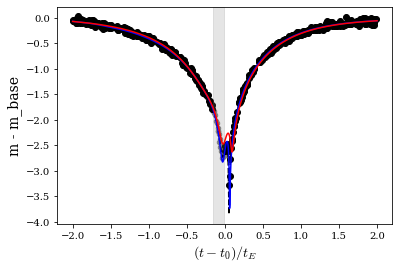

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.14893186 -1.94361442 -0.14771201  0.95599799 -0.22301549]
pred no gap:  [ 0.14314313 -1.8218218  -0.15435436  0.9389389  -0.22522523]
pred gap close:  [ 0.14414415 -1.7737738  -0.14354356  0.9569569  -0.22922923]
pred gap global:  [ 0.14414415 -1.7737738  -0.14354356  0.9569569  -0.22922923]
tensor(164)


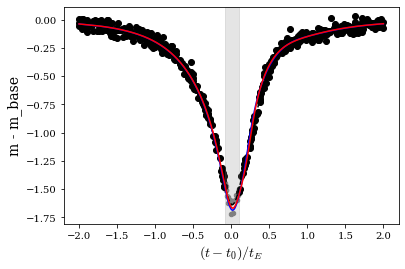

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.17546313 -0.49371153 -0.30239157  1.07936559 -0.10194381]
pred no gap:  [ 0.16816817 -0.4844845  -0.32372373  1.0930932  -0.1031031 ]
pred gap close:  [ 0.19019018 -0.6606607  -0.2864865   1.043043   -0.1041041 ]
pred gap global:  [ 0.16016015 -0.6606607  -0.2864865   1.043043   -0.1041041 ]
tensor(186)


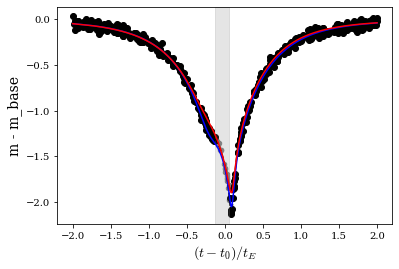

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.00264497 -2.06558737 -0.2164389   0.60230312 -0.23623654]
pred no gap:  [ 0.004004   -2.05005     0.2744745   0.5225225  -0.23523523]
pred gap close:  [ 0.00900901 -1.9179178  -0.19519521  0.5165165  -0.22822823]
pred gap global:  [ 0.00900901 -1.9179178  -0.45225227  0.5165165  -0.22822823]
tensor(76)


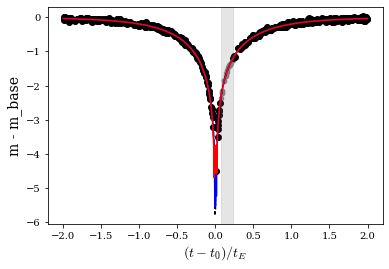

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.03583621 -0.42257918 -0.1096019   1.95212943 -0.08010285]
pred no gap:  [ 0.01901902 -0.992993    0.06186187  0.5465465  -0.07407407]
pred gap close:  [ 0.02102102 -0.25625625 -0.08348349  1.91992    -0.06206206]
pred gap global:  [ 0.02102102 -0.9489489   0.17717719  0.5285285  -0.06206206]
tensor(163)


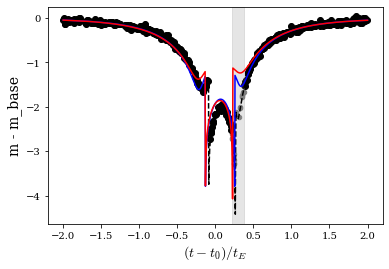

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.00312974 -1.74233074  0.27963645  0.7295124  -0.6892099 ]
pred no gap:  [ 0.01201201 -1.8138138   0.28888893  0.8008008  -0.6906907 ]
pred gap close:  [ 0.00800801 -1.7217216   0.13633634  0.6346346  -0.6966967 ]
pred gap global:  [ 0.00800801 -1.7217216   0.13633634  0.6346346  -0.6966967 ]
tensor(198)


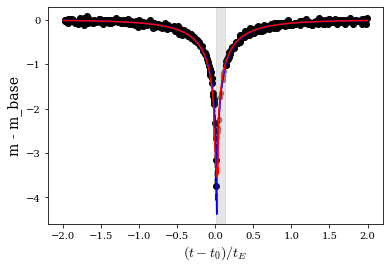

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.07004417 -1.47507082 -0.13744048  0.97851171 -0.21360443]
pred no gap:  [ 0.06006006 -1.4854854  -0.13753755  0.9669669  -0.22022022]
pred gap close:  [ 0.05605606 -1.3133134  -0.16396397  0.9329329  -0.25425425]
pred gap global:  [ 0.05605606 -1.3133134   0.2780781   1.7257258  -0.25425425]
tensor(208)


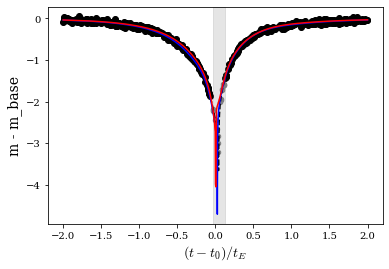

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.02953935 -0.61579998  0.06625534  0.99390781 -0.16385844]
pred no gap:  [ 0.06706706 -0.6606607   0.0906907   1.061061   -0.18018018]
pred gap close:  [ 0.07807808 -0.7687688   0.0978979   1.057057   -0.17717718]
pred gap global:  [ 0.07807808 -0.7687688   0.0978979   1.057057   -0.17717718]
tensor(118)


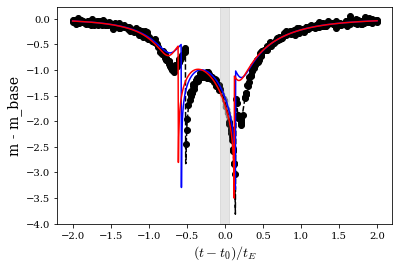

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.19582663 -0.06803667  0.18475217  1.00519035 -0.08713437]
pred no gap:  [ 0.04604604 -0.08408408  0.187988    1.009009   -0.09209209]
pred gap close:  [ 0.1921922  -0.16416416  0.17957959  0.87687683 -0.01501501]
pred gap global:  [ 0.3103103  -0.16416416  0.17957959  1.1451452  -0.01501501]
tensor(71)


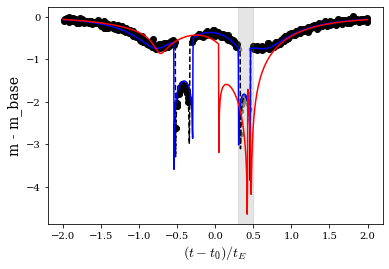

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.00630692 -0.98523216 -0.13643919  0.04465035 -0.78537446]
pred no gap:  [ 0.01501502 -1.057057   -0.0846847   1.945946   -0.7837838 ]
pred gap close:  [ 0.01901902 -1.113113   -0.04264265  0.12412412 -0.7877878 ]
pred gap global:  [ 0.01901902 -1.113113   -0.04264265  1.965966   -0.7877878 ]
tensor(230)


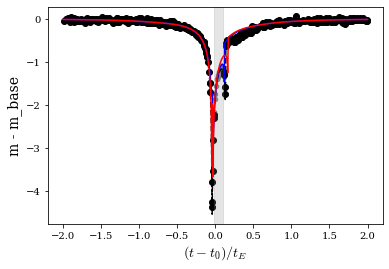

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.12004269 -0.28089255 -0.12973571  0.74204089 -0.34881864]
pred no gap:  [ 0.12612613 -0.22022022 -0.15195197  0.8828829  -0.34534535]
pred gap close:  [ 0.1041041  -0.2002002  -0.16156158  0.5905906  -0.38238236]
pred gap global:  [ 0.1041041  -0.2002002  -0.16156158  0.5905906  -0.38238236]
tensor(15)


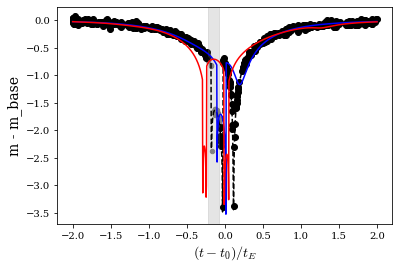

In [125]:
n=14*7
for i in torch.mean((Y[ind][:size] - pred_gap[2][ind[:size]])**2, dim=1).argsort()[n:n+14]:
# i = 167
# fig = plt.figure(1, (4, 8))
    plt.xlabel(r'$(t - t_0)/t_E$', fontsize=14)
    plt.ylabel(r'm - m_base', fontsize=14)
    # plt.gca().set_aspect(0.2)
    # plt.xlim(-0.5, 0.5)
    plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2, color='grey', marker='o', s=20, rasterized=True)
    gap_times = np.setdiff1d(np.floor(X[ind][i, :, 0]*1e3), np.floor(X_gap[ind][i, :, 0]*1e3))/1e3
    plt.axvspan(gap_times.min(), gap_times.max(), color='grey', alpha=0.2)
    plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2, color='black', marker='o', rasterized=True)
    param_true = Y[ind][i].tolist()
    param_true.insert(1, -3)
    param_pred = pred_close[ind[:size]][i].tolist()
    param_pred.insert(1, -3)
    param_pred_gap = pred_gap[2][ind[:size]][i].tolist()
    param_pred_gap.insert(1, -3)
    lc_true = simulate_lc(0, 1, *param_true, orig=True)
    lc_pred = simulate_lc(0, 1, *param_pred, orig=True)
    lc_pred_gap = simulate_lc(0, 1, *param_pred_gap, orig=True)
    # lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
    plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
    plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
    plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='close/global')
    # plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
    param_gt_example = Y[ind][i].numpy()
    param_predgap_example = pred_gap[2][ind[:size]][i].numpy()
    print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
    print('ground truth: ', Y[ind][i].numpy())
    print('pred no gap: ', pred_global[ind[:size]][i].numpy())
    print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
    print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
    print(i)
# plt.gca().invert_yaxis()
# plt.legend()
# param_list = [Y[ind][i].tolist(), pred_global[ind[:size]][i].tolist(), pred_gap[2][ind[:size]][i].tolist()]
# traj_color = ['black', 'blue', 'red']
# cau_color = ['black', 'blue', 'red']
# plt.axes([0.32, 0.17, 0.4, 0.15])
# plt.axis('equal')
# plt.xlim(-0.5, 1)
# plt.ylim(-0.3, 0.3)
# plt.yticks([-0.5, 0, 0.5])
# for i, params in enumerate(param_list):
#     if i != 1:
#         u_0, lgrho, lgq, lgs, alpha_180, lgfs = params
#         parameters = {
#                     't_0': 0,
#                     't_E': 1,
#                     'u_0': u_0,
#                     'rho': 10**lgrho, 
#                     'q': 10**lgq, 
#                     's': 10**lgs, 
#                     'alpha': alpha_180*180,
#                 }
#         modelmm = mm.Model(parameters, coords=None)
#         if i == 0:
#             modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[i], linestyle='dashed')
#         else:
#             modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[i])
#         modelmm.plot_caustics(color=cau_color[i], s=0.3)
# plt.savefig('./lc.pdf')
    plt.show()

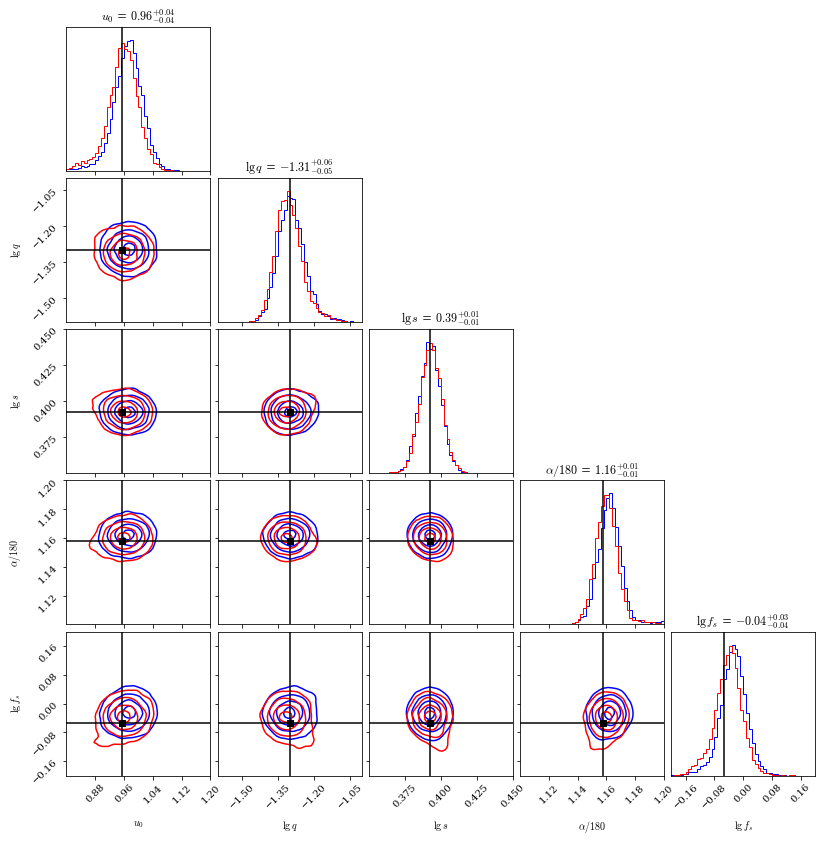

In [40]:
n = int(1e4)

pi = pis[ind[:size]][i]; loc = locs[ind[:size]][i]; scale = scales[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample = model.sample(pi_dist, normal).numpy()
sample = np.delete(sample, 1, axis=1)

pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample_gap = model.sample(pi_dist, normal).numpy()
loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
loglik = torch.sum(loglik, dim=2)
loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
sample_gap = np.delete(sample_gap, 1, axis=1)

truths = Y[ind][i].numpy()
truths = np.delete(truths, 1)

range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths, truth_color='black', 
            fill_contours=False, color='red',  no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
# plt.legend()
plt.show()

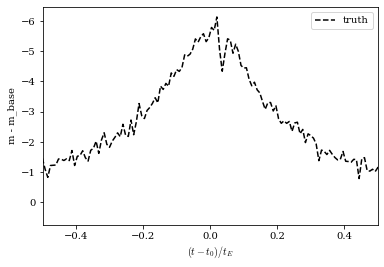

In [35]:
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
plt.xlim(-0.5, 0.5)
test_p = [0.1, -2.301, -3.301, -0, 110/180, np.log10(0.2)]
lc_true = simulate_lc(0, 1, *test_p, orig=False, n_points=500, relative_uncertainty=0.03)
# lc_pred = simulate_lc(0, 1, *pred_global[ind[:size]][i].tolist(), orig=True)
# lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
# plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
# plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
# print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
# print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
# print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
# print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [36]:
X_test = torch.tensor(lc_true.reshape(1, -1, 2)).float()
depth = 3; window_length = max(X_test.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_test, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)
with torch.no_grad():
    pi, normal = model(coeffs.to(device))

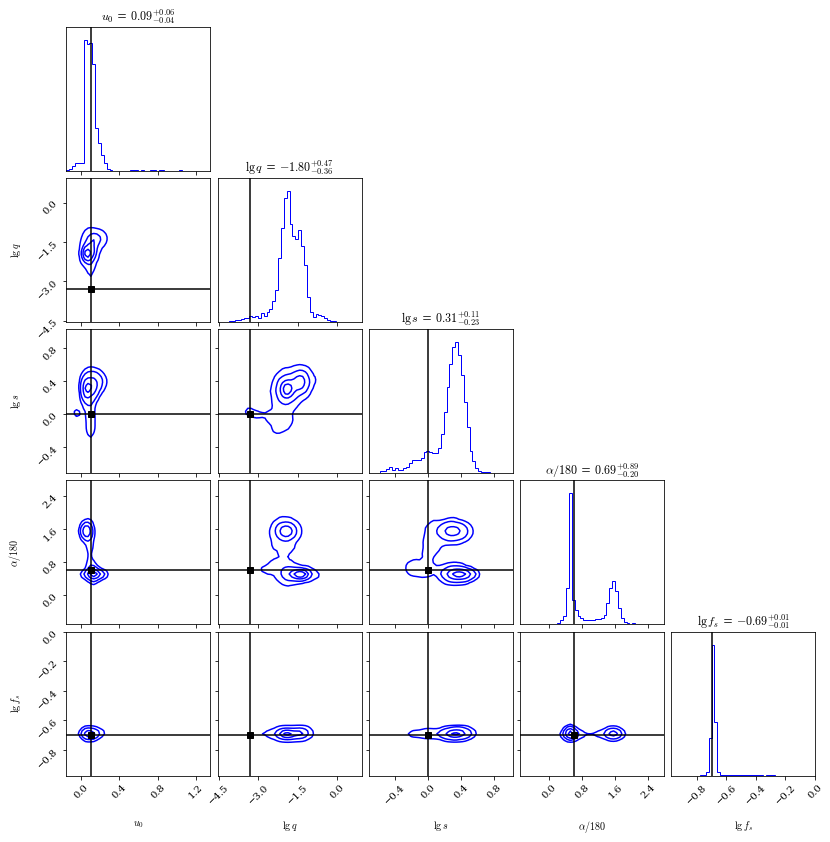

In [37]:
n = int(1e4)

pi = pi.probs.cpu(); loc = normal.loc.cpu(); scale = normal.scale.cpu()
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample = model.sample(pi_dist, normal).numpy()
sample = np.delete(sample, 1, axis=1)

# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
# pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
# normal = torch.distributions.Normal(loc, scale)
# pi_dist = torch.distributions.OneHotCategorical(probs=pi)
# sample_gap = model.sample(pi_dist, normal).numpy()
# loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
# loglik = torch.sum(loglik, dim=2)
# loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
# np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
# sample_gap = np.delete(sample_gap, 1, axis=1)

truths = np.array(test_p)
truths = np.delete(truths, 1)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths, truth_color='black', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
# corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
#             # quantiles=[0.16, 0.5, 0.84], 
#             smooth=1,
#             bins=50,
#             range=range_p,
#             show_titles=True, title_kwargs={"fontsize": 12},
#             truths=truths, truth_color='black', 
#             fill_contours=False, color='red',  no_fill_contours=True,
#             plot_datapoints=False, plot_density=False,
#             # levels=[sigma_level, 0.7],
#             )
# plt.legend()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

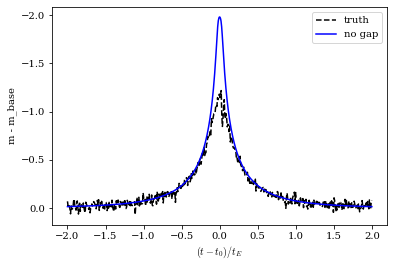

In [38]:
pred_test = get_peak_pred(pi[[0]], loc[[0]], scale[[0]])[0].flatten()
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
# plt.xlim(-0.5, 0.5)
test_p = [0.1, -2.301, -3.301, -0, 110/180, np.log10(0.2)]
lc_true = simulate_lc(0, 1, *test_p, orig=True, n_points=500, relative_uncertainty=0.03)
lc_pred = simulate_lc(0, 1, *(pred_test.tolist()), orig=True)
# lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
# plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
# print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
# print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
# print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
# print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [253]:
from scipy.optimize import minimize
x = pred_global[ind[:size]][i].tolist()
x[3] = -0.4
# x = [0.05, -2.816816806793213, -0.9, -0.24, 1.22, -0.22]
pi = pis[ind[:size]][i]; loc = locs[ind[:size]][i]; scale = scales[ind[:size]][i]
# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
result = minimize(lambda x: model.mdn_loss(pi_dist, normal, torch.tensor(x).reshape(-1, 6)), x)
print(result)

      fun: -9.560304460732526
 hess_inv: array([[ 3.80401611e-05,  4.25880733e-04, -1.11635014e-05,
        -1.39091560e-05,  3.58076218e-05, -5.13149730e-06],
       [ 4.25880733e-04,  2.40342761e-01,  1.77160874e-02,
        -5.28511929e-03,  4.69830500e-04, -1.57031497e-03],
       [-1.11635014e-05,  1.77160874e-02,  2.72658589e-02,
         2.04159331e-04, -8.58224342e-04,  1.89286446e-05],
       [-1.39091560e-05, -5.28511929e-03,  2.04159331e-04,
         1.00407056e-03, -1.46357420e-04,  4.57553916e-05],
       [ 3.58076218e-05,  4.69830500e-04, -8.58224342e-04,
        -1.46357420e-04,  8.63464396e-02, -1.00963254e-05],
       [-5.13149730e-06, -1.57031497e-03,  1.89286446e-05,
         4.57553916e-05, -1.00963254e-05,  1.19486919e-04]])
      jac: array([-9.29832458e-06,  0.00000000e+00, -3.57627869e-07,  4.88758087e-06,
        0.00000000e+00,  1.45435333e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 147
      nit: 15
     njev: 2

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.09807598 -3.12932717 -1.71259524  0.28449352  1.1236783  -0.24157655]
pred no gap:  [ 0.1021021  -3.0470471  -1.7657658   0.2924925   1.1531532  -0.24024025] prob density:  167341.52
pred gap close:  [ 0.11511511 -3.0570571  -1.6976976   0.2804805   1.1951952  -0.23323323] prob density:  465.12793
pred gap second:  [ 0.11117535 -3.06756953 -0.99334267 -0.34256337  1.21580687 -0.23754606] prob density:  14190.165890277709
82


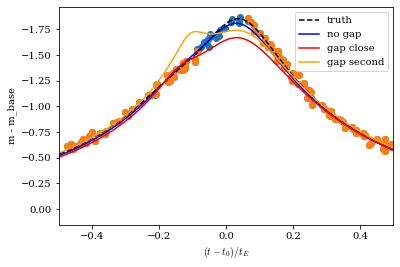

In [254]:
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
plt.xlim(-0.5, 0.5)
plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2)
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2)
lc_true = simulate_lc(0, 1, *Y[ind][i].tolist(), orig=True)
lc_pred = simulate_lc(0, 1, *pred_global[ind[:size]][i].tolist(), orig=True)
lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# pred_gap_sec = pred_gap[0][ind[:size]][i].tolist()
# pred_gap_sec[0] = 0.05; pred_gap_sec[2] = -0.9; pred_gap_sec[3] = -0.24; pred_gap_sec[4] = 1.22; pred_gap_sec[5] = -0.22
pred_gap_sec = result['x']
lc_pred_gap_sec = simulate_lc(0, 1, *pred_gap_sec, orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
plt.plot(lc_pred_gap_sec[:, 0], lc_pred_gap_sec[:, 1], color='orange', label='gap second')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', Y[ind][i].numpy())
print('pred no gap: ', pred_global[ind[:size]][i].numpy(), 'prob density: ', np.exp(pred_global_loglik[ind[:size]][i].numpy().sum()))
print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy(), 'prob density: ', np.exp(pred_gap[3][ind[:size]][i].numpy().sum()))
print('pred gap second: ', pred_gap_sec, 'prob density: ', np.exp(-result['fun']))
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Even

In [128]:
X_even = np.zeros((size, X.shape[-2], X.shape[-1]))
for i in tqdm(range(size)):
    param = Y[i].tolist()
    param.insert(1, -3)
    lc = simulate_lc(0, 1, *param, relative_uncertainty=0.03, n_points=500)
    X_even[i] = lc
np.save('./KMT-fixrho-even.npy', X_even)

  0%|          | 0/16384 [00:00<?, ?it/s]

In [129]:
X_even = np.load('./KMT-fixrho-even.npy')

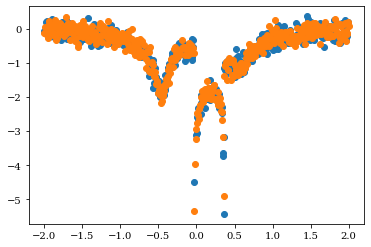

(0.007602871574271546, 1.9878191484637504e-17)

In [130]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_even[i, :, 0], X_even[i, :, 1])
plt.show()
np.diff(X[i, :, 0]).std(), np.diff(X_even[i, :, 0]).std()

In [132]:
X_even = torch.tensor(X_even)
# CDE interpolation with log_sig
depth = 3; window_length = max(X_even.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)
pis, locs, scales = inference(model, size, 4096, coeffs, device)

/tmp/ipykernel_658983/1861338275.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_even = torch.tensor(X_even)


  0%|          | 0/4 [00:00<?, ?it/s]

In [133]:
pred_even = get_peak_pred(pis, locs, scales, Y)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.06346746048288449
mse of log10q close:  0.029582295063698263
constraint 0.99310302734375
correct 0.9225616126851454
mse of log10s global:  0.011913740585257784
mse of log10s close:  0.0015453670200837669
constraint 0.98175048828125
correct 0.8928193969536835
mse of u0:  0.009101388394584804
mse of u0:  0.0031659082474716784
constraint 0.98846435546875
correct 0.9091694967582588
mse of alpha global:  5968.59090426096
mse of alpha close:  244.71654730122202
constraint 0.98468017578125
correct 0.786028636955309
mse of log10fs global:  0.0024323276159479755
mse of log10fs close:  0.0013489054887615907


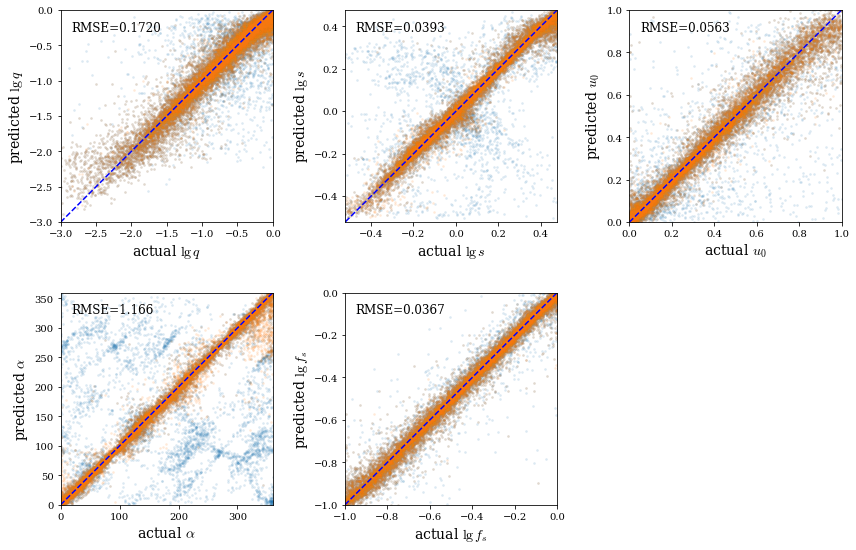

In [134]:
# plot_params(size, Y, *pred_even, '500 regular, 33 S/N', save='./500reg33SN.pdf')
rmse_even = plot_params(size, Y, *pred_even, title=None, save='./500reg33SN.pdf')

In [135]:
pred_even[1].sum(dim=1).mean(), pred_even[3].sum(dim=1).mean()

(tensor(10.9451), tensor(10.4165))

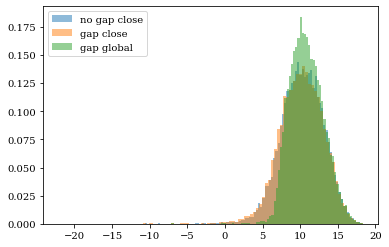

In [136]:
plt.hist(pred_close_loglik.numpy().sum(1), bins=100, density=True, label='no gap close', alpha=0.5)
plt.hist(pred_gap[3].numpy().sum(1), bins=100, density=True, label='gap close', alpha=0.5)
plt.hist(pred_gap[1].numpy().sum(1), bins=100, density=True, label='gap global', alpha=0.5)
plt.legend()
plt.show()

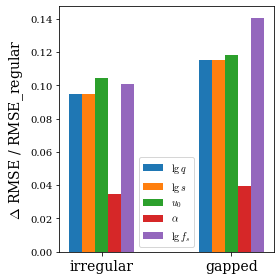

In [137]:
mse_close = np.load('./mse_sub.npy')
rmse_sub = np.sqrt(mse_close[:, [2, 3, 0, 4, 5]]).T

fig = plt.figure(figsize=(4, 4))
width = 0.1
labels = [r'$\lg q$', r'$\lg s$', r'$u_0$', r'$\alpha$', r'$\lg f_s$']
cats = ['500\nregular', 'irregular', 'gapped', '400', '300', '200', '100']
markers = ['o', 's', '^', '+', 'x']
rmses = np.stack([rmse_even, rmse, rmse_gap], axis=-1)
rmses = np.hstack([rmses, rmse_sub])
rmses = rmses / rmses[:, [0]]
left = 1; right = -4
for i, label in enumerate(labels):
    plt.bar(np.arange(len(cats[left:right]))+(i-2)*width, rmses[i, left:right]-1, width, label=label)
    # plt.plot(cats[left:right], rmses[i, left:right]-1, linestyle='dashed')
plt.ylabel(r'$\Delta$ RMSE / RMSE_regular', fontsize=14)
plt.ylim(bottom=0)
plt.xticks(np.arange(len(cats[left:right])), cats[left:right], fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./rmse.pdf')
plt.show()

mse of log10q global:  0.07645586302080136
mse of log10q close:  0.03763054552652344
constraint 0.99932861328125
correct 0.9092408233066634
mse of log10s global:  0.014511998007188063
mse of log10s close:  0.0019218633568419607
constraint 0.98138427734375
correct 0.8660364450525531
mse of u0:  0.011663608080675932
mse of u0:  0.003956700578892095
constraint 0.98834228515625
correct 0.8908170196998703
mse of alpha global:  6696.900037856027
mse of alpha close:  264.2942754407211
constraint 0.984619140625
correct 0.7599181750557897
mse of log10fs global:  0.0030737125151016178
mse of log10fs close:  0.0017540620577256873
constraint 0.99676513671875
correct 0.9369297654767007


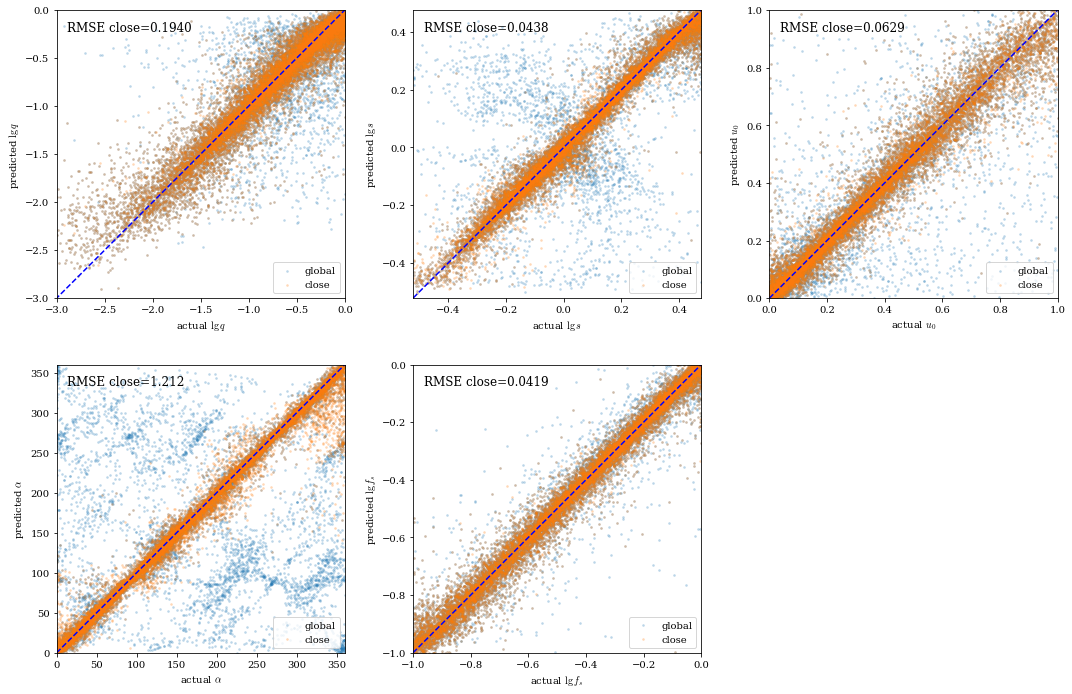

In [138]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = pred_gap

fig = plt.figure(figsize=(15, 10))
axq = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=1)
axq.axis('square')
axq.set_xlim(-3, 0)
axq.set_ylim(-3, 0)
axq.set_xlabel(r'actual $\lg q$')
axq.set_ylabel(r'predicted $\lg q$')
axq.scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
axq.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
axq.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
axq.legend(loc='lower right')
print('mse of log10q global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num,1])**2).detach().cpu().item())
print('mse of log10q close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/4)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())
at = AnchoredText(
    "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
axq.add_artist(at)
rmse.append(np.sqrt(torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item()))

axs = plt.subplot2grid(shape=(2, 3), loc=(0, 1), rowspan=1, colspan=1)
axs.axis('square')
axs.set_xlim(np.log10(0.3), np.log10(3))
axs.set_ylim(np.log10(0.3), np.log10(3))
axs.set_xlabel(r'actual $\lg s$')
axs.set_ylabel(r'predicted $\lg s$')
axs.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
axs.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
axs.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
axs.legend(loc='lower right')
print('mse of log10s global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
print('mse of log10s close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/2/np.log10(3))
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())
at = AnchoredText(
    "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
axs.add_artist(at)
rmse.append(np.sqrt(torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item()))

axu = plt.subplot2grid(shape=(2, 3), loc=(0, 2), rowspan=1, colspan=1)
axu.axis('square')
axu.set_xlim(0, 1)
axu.set_ylim(0, 1)
axu.set_xlabel(r'actual $u_0$')
axu.set_ylabel(r'predicted $u_0$')
axu.scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
axu.scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
axu.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
axu.legend(loc='lower right')
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())
at = AnchoredText(
    "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
axu.add_artist(at)
rmse.append(np.sqrt(torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item()))

axa = plt.subplot2grid(shape=(2, 3), loc=(1, 0), rowspan=1, colspan=1)
axa.axis('square')
axa.set_xlim(0, 360)
axa.set_ylim(0, 360)
axa.set_xlabel(r'actual $\alpha$')
axa.set_ylabel(r'predicted $\alpha$')
axa.scatter(Y[:num, 3]*180, pred_global.numpy()[:num, 3]*180, s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
axa.scatter(Y[:num, 3]*180, pred_close.numpy()[:num, 3]*180, s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
axa.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
axa.legend(loc='lower right')
print('mse of alpha global: ', torch.mean((Y[:num, 3]*180 -  pred_global.numpy()[:num, 3]*180)**2).detach().cpu().item())
print('mse of alpha close: ', torch.mean((Y[:num, 3]*180 -  pred_close.numpy()[:num, 3]*180)**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())
at = AnchoredText(
    "RMSE close=%.3f" % np.sqrt((torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())*180), prop=dict(size=12), frameon=False, loc='upper left')
axa.add_artist(at)
rmse.append(np.sqrt(torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item()))

axf = plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=1)
axf.axis('square')
axf.set_xlim(-1, 0)
axf.set_ylim(-1, 0)
axf.set_xlabel(r'actual $\lg f_s$')
axf.set_ylabel(r'predicted $\lg f_s$')
axf.scatter(Y[:num, 4], pred_global.numpy()[:num, 4], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
axf.scatter(Y[:num, 4], pred_close.numpy()[:num, 4], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
axf.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
axf.legend(loc='lower right')
print('mse of log10fs global: ', torch.mean((Y[:num, 4] -  pred_global.numpy()[:num, 4])**2).detach().cpu().item())
print('mse of log10fs close: ', torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())
at = AnchoredText(
    "RMSE close=%.4f" % np.sqrt((torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
axf.add_artist(at)
rmse.append(np.sqrt(torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item()))

# axr = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1, colspan=1)
# axr.set_aspect(4 / 0.3)
# # axr.set_xlim(0, 4)
# # axr.set_ylim(1, 1.5)
# for i, label in enumerate(labels):
#     axr.scatter(cats[:trunc], rmses[i, :trunc], label=labels[i], marker=markers[i])
#     axr.plot(cats[:trunc], rmses[i, :trunc], linestyle='dashed')
# axr.set_ylabel('RMSE / RMSE_regular')
# axr.legend()

plt.tight_layout()

plt.savefig('./gap+rmse.pdf')
plt.show()